# Visium HD dataset

In [62]:
#! /opt/homebrew/bin/python3 -m pip install scanpy

In [63]:
import scanpy as sc

import matplotlib.pyplot as plt

plt.style.use('dark_background')


## Normalize the spatial dataset

In [64]:

# Had to symlink to image paths into the "spatial" directory within visium_dataset_path
# These are Postnatal Day 7, Wild-type, CD-1 IGS Mice from Charles River

import spatialdata_io as sdio
from spatialdata_io.experimental import to_legacy_anndata

visium_dataset_path = "../Shults_SpatialData/binned_outputs/"
bin_008_dataset_path = "{}/square_008um/".format(visium_dataset_path)

In [65]:
# Convert tissue position parquet file into csv so it can be read by scanpy read_visium function

import pandas as pd
df = pd.read_parquet("{}/spatial/tissue_positions.parquet".format(bin_008_dataset_path))
df.to_csv("{}/spatial/tissue_positions_list.csv".format(bin_008_dataset_path), index=False)

In [66]:
# https://github.com/scverse/spatialdata-io/issues/212

# Create a symlink for feature_slice.h5 within "visium_dataset_path" to include a "spatialdata_" prefix
# This is a workaround for the current implementation of the visium_hd function

import os

absolute_path = os.path.abspath(visium_dataset_path)

if not os.path.exists("{}/spatialdata_feature_slice.h5".format(visium_dataset_path)):
    os.symlink("{}/feature_slice.h5".format(absolute_path), "{}/spatialdata_feature_slice.h5".format(visium_dataset_path))


In [67]:
vis_sdata = sdio.visium_hd(visium_dataset_path
                        , dataset_id="spatialdata"   # Provide a name to standarize downstream usage
                        , bin_size=8
                        , filtered_counts_file=True
                        , load_all_images=False
                        , fullres_image_file=None
                        , bins_as_squares=True
                        )

/opt/homebrew/lib/python3.12/site-packages/anndata/_core/anndata.py:1820: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/var/folders/ms/ft2j_6k51t99np3jqp17lj9r0000gp/T/ipykernel_71118/3045687375.py:1: UserWarning: No full resolution image found. If incorrect, please specify the path in the `fullres_image_file` parameter when calling the `visium_hd` reader function.
  vis_sdata = sdio.visium_hd(visium_dataset_path


In [68]:
#vis_adata = sc.read_visium(visium_dataset_path)
#vis_sdata = sdio.visium(visium_dataset_path, dataset_id="D1")    # visium_hd function does not work (no inferred dataset id)
# D1 is what I think is the dataset ID based on the vis_adata.uns["spatial"] metadata
vis_sdata

SpatialData object
├── Images
│     ├── 'spatialdata_hires_image': DataArray[cyx] (3, 3866, 6000)
│     └── 'spatialdata_lowres_image': DataArray[cyx] (4, 3000, 3200)
├── Shapes
│     └── 'spatialdata_square_008um': GeoDataFrame shape: (97750, 1) (2D shapes)
└── Tables
      └── 'square_008um': AnnData (97750, 19059)
with coordinate systems:
    ▸ 'downscaled_hires', with elements:
        spatialdata_hires_image (Images), spatialdata_square_008um (Shapes)
    ▸ 'downscaled_lowres', with elements:
        spatialdata_lowres_image (Images), spatialdata_square_008um (Shapes)
    ▸ 'global', with elements:
        spatialdata_square_008um (Shapes)

INFO     Dropping coordinate system 'global' since it doesn't have relevant elements.                              
INFO     Rasterizing image for faster rendering.                                                                   
INFO     Rasterizing image for faster rendering.                                                                   


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.4615763168012303..3.2598385236447522].


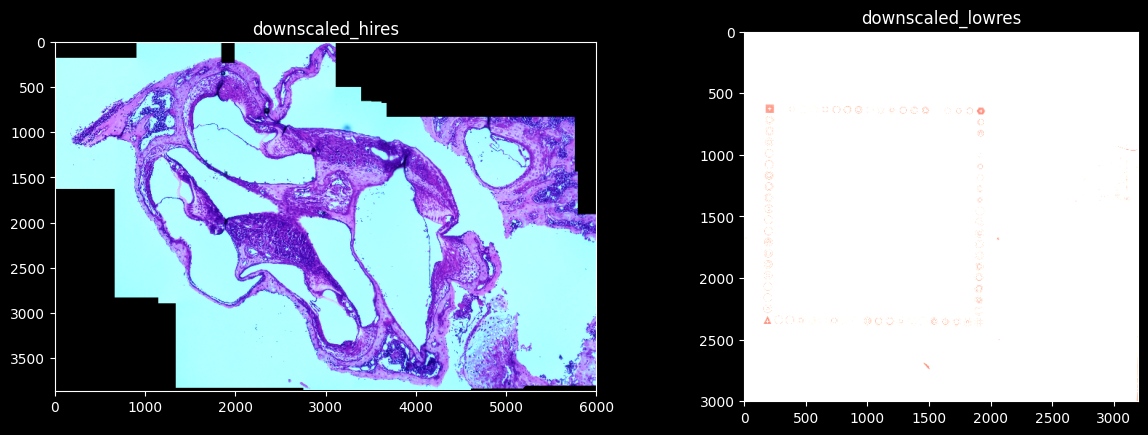

In [69]:
import spatialdata_plot
#try:
    #vis_sdata.pl.render_images().pl.show()
#except:
    # gives some error about the "global" coordinate system which totally just ignored last time I ran this
#    pass
vis_sdata.pl.render_images().pl.show()


In [90]:
vis_sdata["square_008um"].shape

(2499, 19059)

In [71]:
# Bounding box query to only get the hires part of the entire image. This should hopefully yield a better result

from spatialdata import bounding_box_query

img_to_use = "spatialdata_hires_image"
x = len(vis_sdata.images[img_to_use].x)
y = len(vis_sdata.images[img_to_use].y)

vis_sdata = bounding_box_query(vis_sdata,
                           axes=("x", "y"),
                           min_coordinate=[1000, 1000],
                           max_coordinate=[2000, 2000], # think this is the Organ of Corti region, according to Chris.  Need to verify
                           #max_coordinate=[x, y],
                           target_coordinate_system="downscaled_hires",
                           filter_table=True,
                           )
"""
# Alternatively, can pass a DataArray to bounding_box_query but cannot filter table.  Returns a DataArray that can be added to the vis_sdata object
query = bounding_box_query(vis_sdata["spatialdata_hires_image"],
                           axes=("x", "y"),
                           min_coordinate=[0, 0],
                           max_coordinate=[3000, 3000],
                           target_coordinate_system="downscaled_hires",
                           filter_table=True,
                           )

vis_sdata["query"] = query
vis_sdata.pl.render_images("query").pl.show()
query.pl.render_images("spatialdata_hires_image").pl.show()
"""


/opt/homebrew/lib/python3.12/site-packages/anndata/_core/anndata.py:1820: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


'\n# Alternatively, can pass a DataArray to bounding_box_query but cannot filter table.  Returns a DataArray that can be added to the vis_sdata object\nquery = bounding_box_query(vis_sdata["spatialdata_hires_image"],\n                           axes=("x", "y"),\n                           min_coordinate=[0, 0],\n                           max_coordinate=[3000, 3000],\n                           target_coordinate_system="downscaled_hires",\n                           filter_table=True,\n                           )\n\nvis_sdata["query"] = query\nvis_sdata.pl.render_images("query").pl.show()\nquery.pl.render_images("spatialdata_hires_image").pl.show()\n'

In [72]:
vis_sdata

SpatialData object
├── Images
│     └── 'spatialdata_hires_image': DataArray[cyx] (3, 1000, 1000)
├── Shapes
│     └── 'spatialdata_square_008um': GeoDataFrame shape: (2499, 1) (2D shapes)
└── Tables
      └── 'square_008um': AnnData (2499, 19059)
with coordinate systems:
    ▸ 'downscaled_hires', with elements:
        spatialdata_hires_image (Images), spatialdata_square_008um (Shapes)
    ▸ 'downscaled_lowres', with elements:
        spatialdata_square_008um (Shapes)
    ▸ 'global', with elements:
        spatialdata_square_008um (Shapes)

In [73]:
vis_adata = to_legacy_anndata(vis_sdata, include_images=True, coordinate_system="downscaled_hires")
vis_adata

/opt/homebrew/lib/python3.12/site-packages/anndata/_core/anndata.py:1820: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/opt/homebrew/lib/python3.12/site-packages/anndata/_core/anndata.py:1820: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/opt/homebrew/lib/python3.12/site-packages/anndata/_core/anndata.py:1820: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


WARNING  The vector part of the transformation matrix is not isotropic, the radius will be scaled by the average of
         the modules of eigenvalues of the affine transformation matrix.                                           
         matrix=[[ 1.91654119e+00  0.00000000e+00 -1.89922395e+03]                                                 
          [ 0.00000000e+00  1.91699444e+00 -1.87557799e+03]                                                        
          [ 0.00000000e+00  0.00000000e+00  1.00000000e+00]]                                                       
         eigenvalues=[1.91654119 1.91699444]                                                                       
         scale_factor=1.9167678184068249                                                                           
WARNING  The vector part of the transformation matrix is not isotropic, the radius will be scaled by the average of
         the modules of eigenvalues of the affine transformation matrix.

/opt/homebrew/lib/python3.12/site-packages/anndata/_core/anndata.py:1820: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/opt/homebrew/lib/python3.12/site-packages/anndata/_core/anndata.py:1820: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/opt/homebrew/lib/python3.12/site-packages/anndata/_core/anndata.py:1820: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


AnnData object with n_obs × n_vars = 2499 × 19059
    obs: 'in_tissue', 'array_row', 'array_col', 'location_id', 'region'
    var: 'gene_ids', 'feature_types', 'genome'
    uns: 'spatialdata_attrs', 'spatial'
    obsm: 'spatial'

In [74]:
vis_adata.var_names_make_unique()

# currently gene symbols are the index, need to move them to a column
#vis_adata.var["gene_symbol"] = vis_adata.var.index

# set the index to the ensembl id (gene_ids)
#vis_adata.var.set_index("gene_ids", inplace=True)

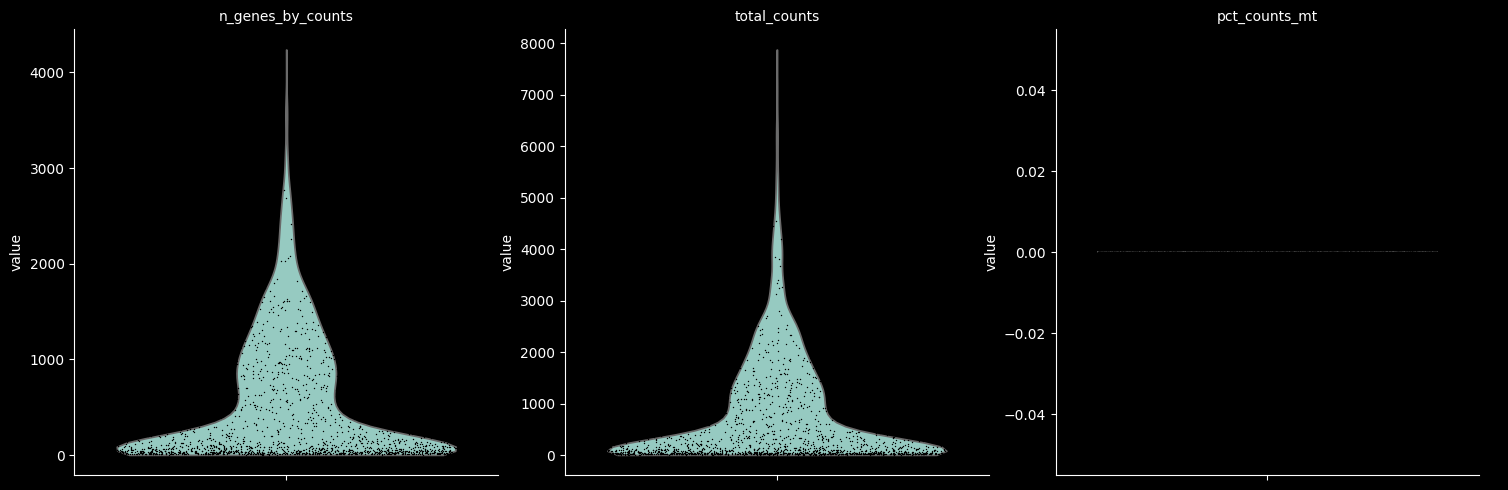

In [75]:
vis_adata.var["mt"] = vis_adata.var_names.str.startswith("MT-")
sc.pp.calculate_qc_metrics(vis_adata, qc_vars=["mt"], inplace=True)
sc.pl.violin(
    vis_adata,
    ["n_genes_by_counts", "total_counts", "pct_counts_mt"],
    jitter=0.4,
    multi_panel=True,
)


In [76]:
sc.pp.filter_cells(vis_adata, min_genes=300)
sc.pp.normalize_total(vis_adata, inplace=True)
sc.pp.log1p(vis_adata)
sc.pp.highly_variable_genes(vis_adata, flavor="seurat", n_top_genes=2000, inplace=True)


In [77]:
marker_genes = ["Pou4f3", "Calb2", "Pvalb", "Smpx", "Mlf1", "Sox2", "Atoh1"]  # 5 random Cochlear HCs P7 + Sox2 and Atoh1

def normalize_marker_genes(gene_list, chosen_genes):
    """Convert to case-insensitive.  Also will not add chosen gene if not in gene list."""
    case_insensitive_genes = [g for cg in chosen_genes for g in gene_list if cg.lower() == g.lower()]
    return case_insensitive_genes

# Reset index to gene symbol to ensure gene names are the plot labels
#vis_adata.var.reset_index(inplace=True)
#vis_adata.var.set_index('gene_symbol', inplace=True)

# Deduplicate gene_symbols
vis_adata = vis_adata[:, vis_adata.var.index.duplicated() == False]

vis_adata.var_names_make_unique()
gene_symbols = vis_adata.var.index.tolist()
marker_genes = normalize_marker_genes(gene_symbols, marker_genes)

num_genes = len(marker_genes)
marker_genes

['Pou4f3', 'Calb2', 'Pvalb', 'Smpx', 'Mlf1', 'Sox2', 'Atoh1']

In [78]:
# get top 5 highly variable genes
highly_variable_genes = vis_adata.var[vis_adata.var.highly_variable].sort_values('dispersions_norm', ascending=False).index.tolist()
if len(highly_variable_genes) > 5:
    highly_variable_genes = highly_variable_genes[:5]
highly_variable_genes

['Ocm', 'S100a8', 'Scg2', 'Kcne1', 'Hbb-bt']

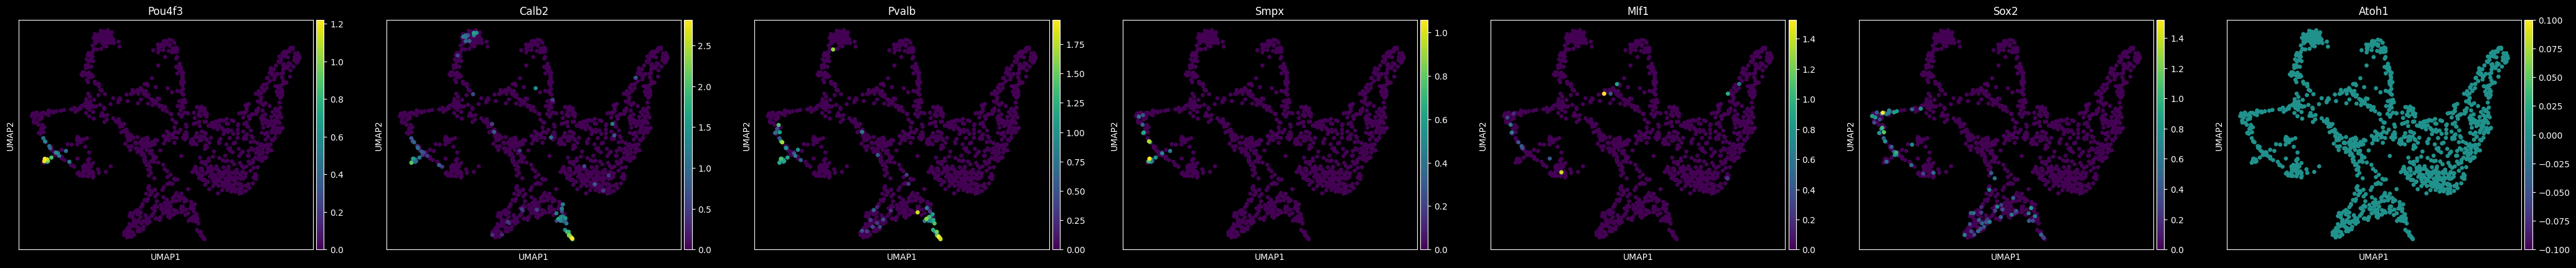

In [79]:
sc.pp.pca(vis_adata)
sc.pp.neighbors(vis_adata)
sc.tl.umap(vis_adata)
umap_ax = sc.pl.umap(vis_adata, color=marker_genes, ncols=num_genes, show=False)
# I keep adjusting until the resolution setting makes clusters roughly match the single-cell clusters
sc.tl.leiden(
    vis_adata, key_added="spatial_clusters", flavor="igraph", directed=False
)

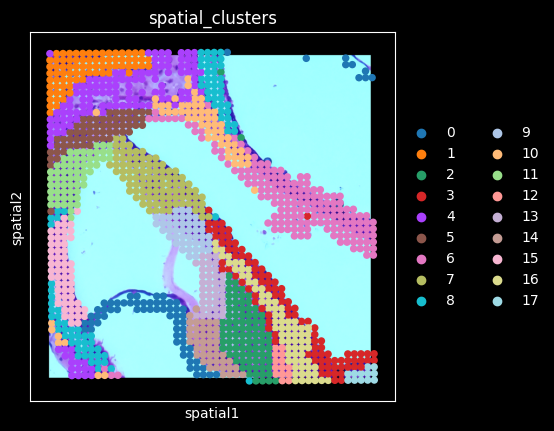

In [80]:
leiden_ax = sc.pl.spatial(vis_adata, img_key="hires", color="spatial_clusters", size=1, library_id="spatialdata_hires_image", show=False)

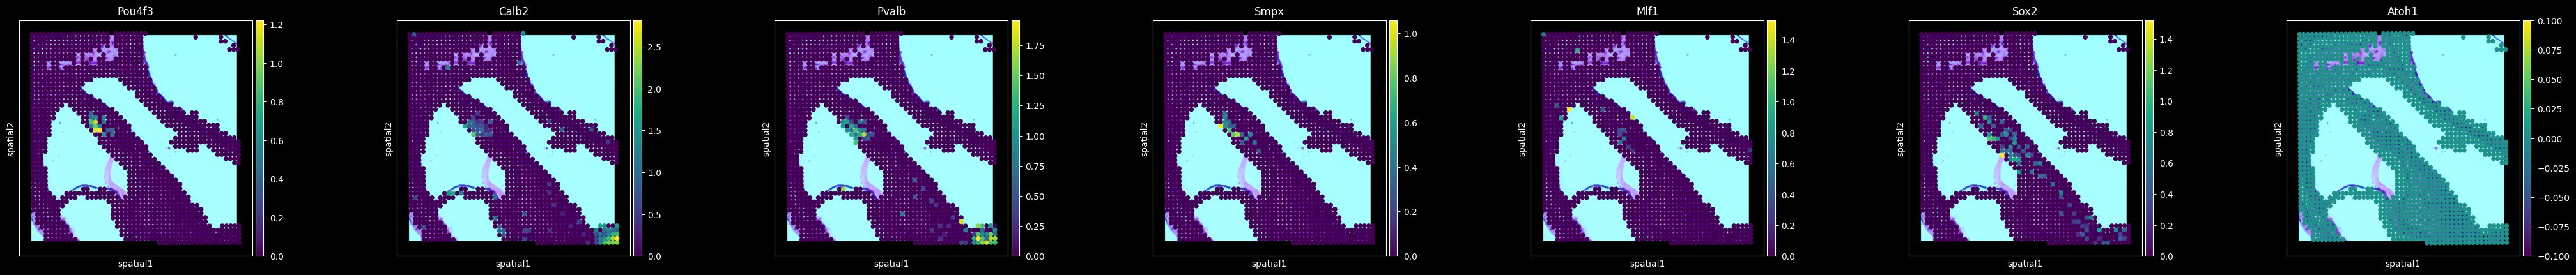

In [81]:
leiden2_ax = sc.pl.spatial(vis_adata, img_key="hires", color=marker_genes, size=1, library_id="spatialdata_hires_image", ncols=num_genes, show=False)

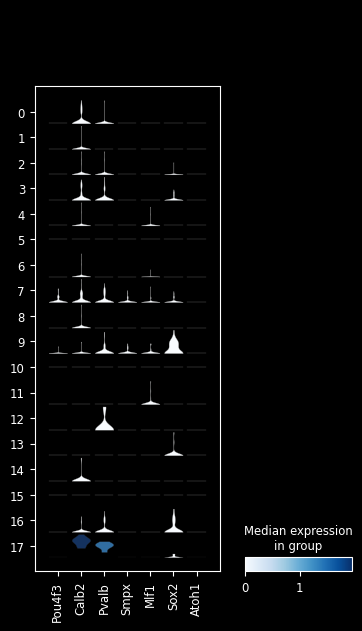

In [82]:
violin_ax = sc.pl.stacked_violin(vis_adata, marker_genes, groupby="spatial_clusters", use_raw=False, show=False)

[<Axes: title={'center': 'spatial_clusters'}, xlabel='spatial1', ylabel='spatial2'>]

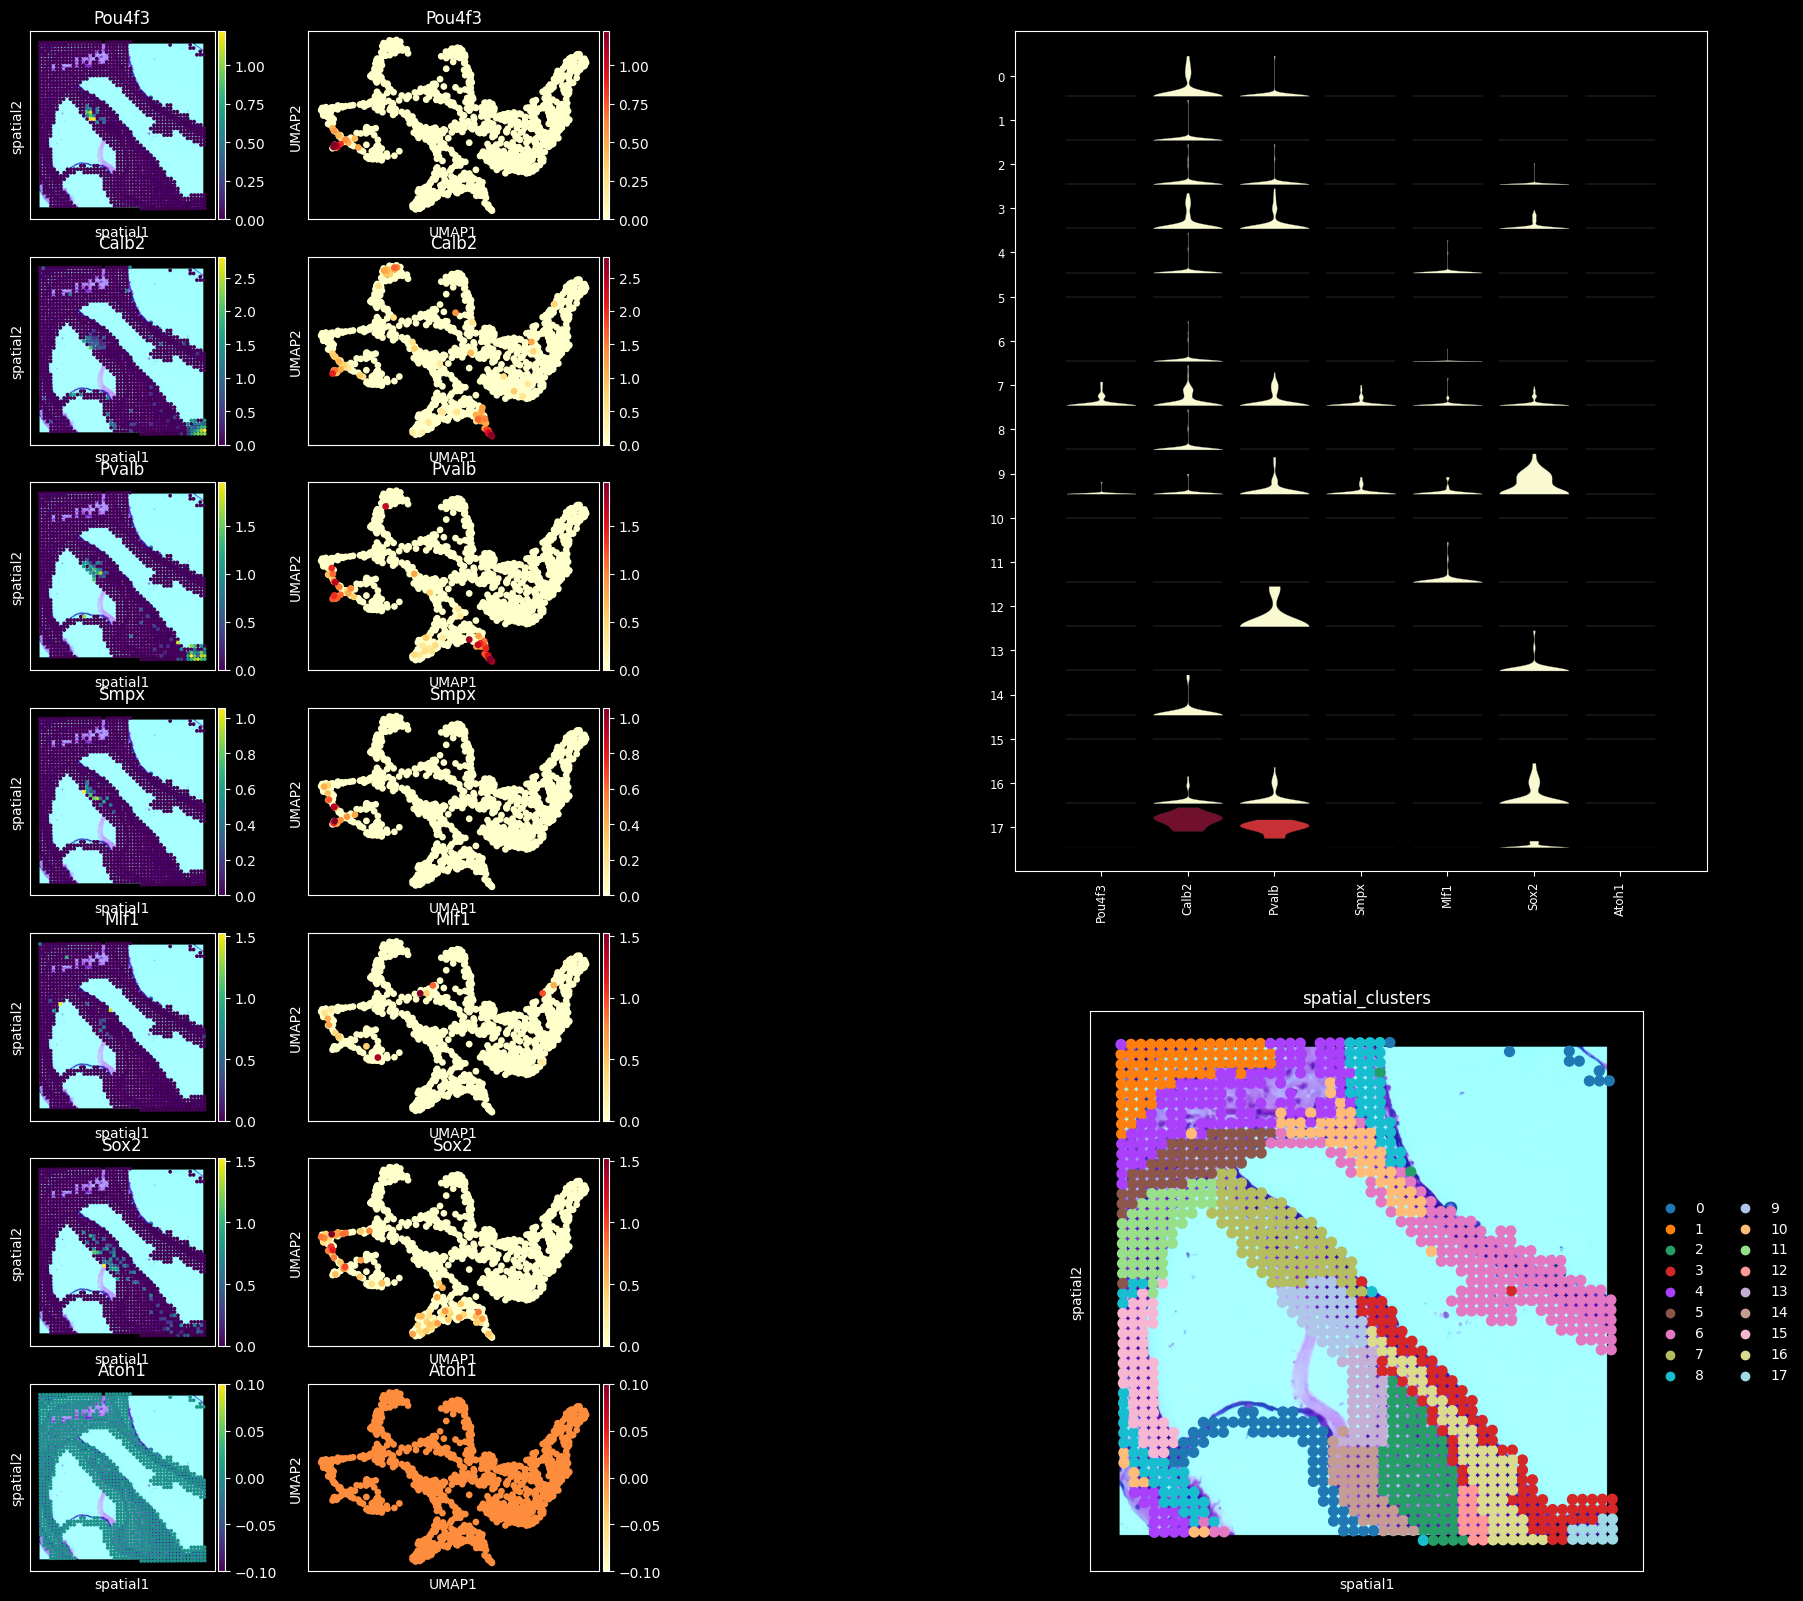

In [83]:
# DRAFT 1
from matplotlib import pyplot as plt

# Split into 2 subfigures.  Left side will be "per-gene" plots, and right side will be "per-cluster" plots
fig = plt.figure(figsize=(20, 20))
subfigs = fig.subfigures(1, 2, wspace=0.2)

ax0 = subfigs[0].subplots(num_genes, 2)
ax_row = 0

for gene in marker_genes:
    sc.pl.spatial(vis_adata, img_key="hires", color=gene, size=1, library_id="spatialdata_hires_image", ax=ax0[ax_row][0], show=False)
    sc.pl.umap(vis_adata, color=gene, ax=ax0[ax_row][1], color_map="YlOrRd", show=False)
    ax_row +=1

ax1, ax2 = subfigs[1].subplots(nrows=2, ncols=1, height_ratios=[0.6, 0.4])

violin_fig = sc.pl.stacked_violin(vis_adata, marker_genes, groupby="spatial_clusters", ax=ax1, cmap="YlOrRd", show=False, return_fig=True, figsize=(20, 20))
# Remove the existing legend and add a new vertically-oriented one
violin_fig.legend(show = False)
violin_fig.make_figure()
#plt.colorbar(violin_fig, cax=ax1.inset_axes([0.95, 0.1, 0.05, 0.8]), ax=ax1, orientation="vertical")

sc.pl.spatial(vis_adata, img_key="hires", color="spatial_clusters", size=1, library_id="spatialdata_hires_image", ax=ax2, show=False)


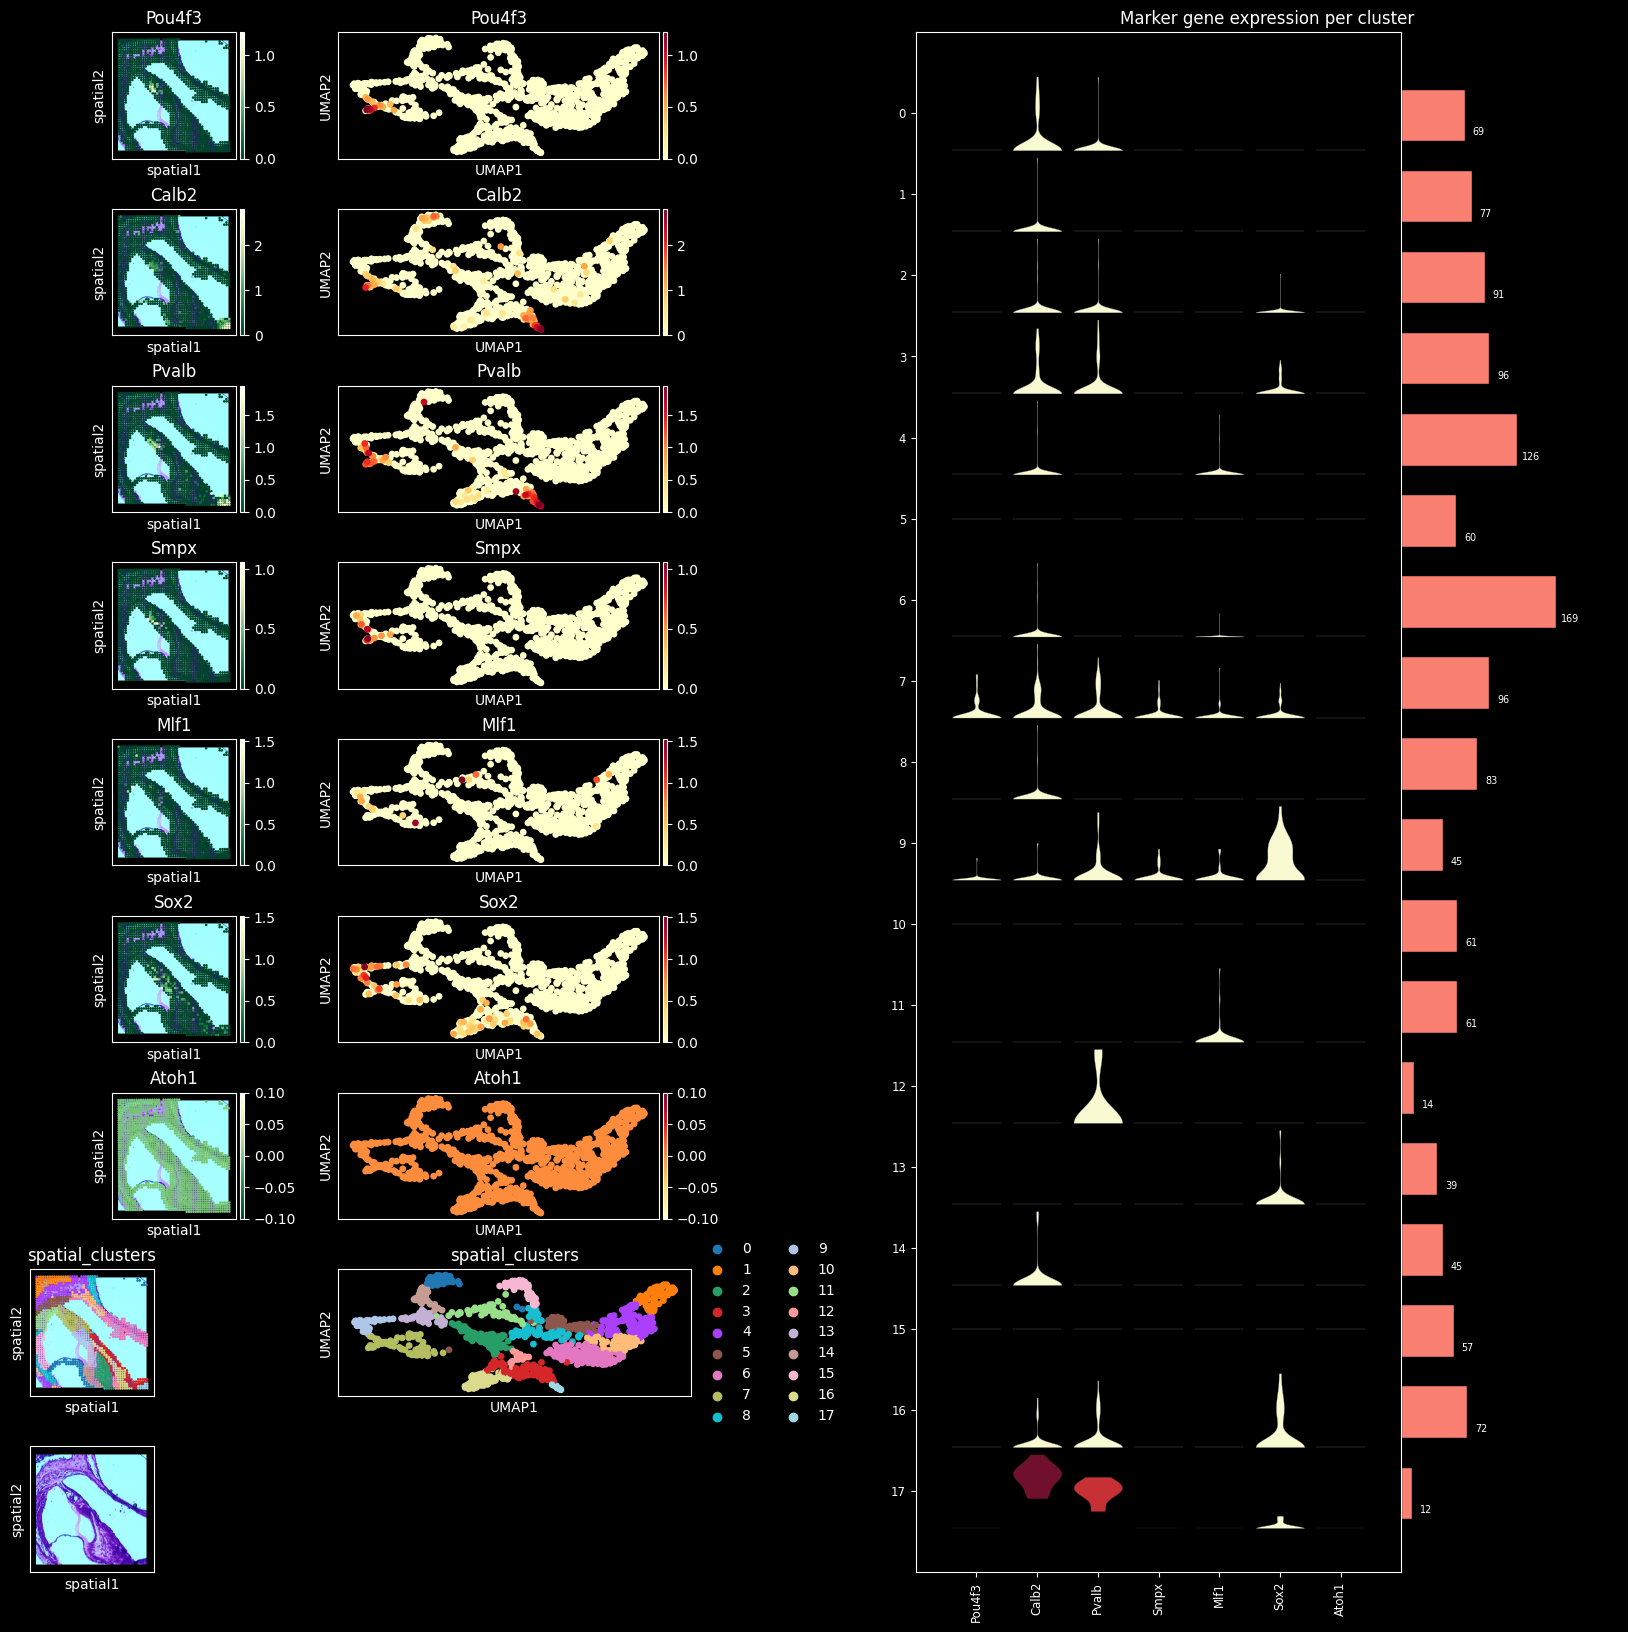

In [84]:
# DRAFT 2 (based on feedback on draft 1)

# Split into 2 subfigures.  Left side will be "per-gene" plots, and right side will be "per-cluster" plots
fig = plt.figure(figsize=(20, 20))
subfigs = fig.subfigures(1, 2)

subfigs[0].subplots_adjust(hspace=0.4)

ax0 = subfigs[0].subplots(num_genes+2, 2)
ax_row = 0

for gene in marker_genes:
    sc.pl.spatial(vis_adata, img_key="hires", color=gene, size=1, library_id="spatialdata_hires_image", ax=ax0[ax_row][0], color_map="YlGn_r", show=False)
    sc.pl.umap(vis_adata, color=gene, ax=ax0[ax_row][1], color_map="YlOrRd", show=False)
    ax_row +=1

# clusters
sc.pl.spatial(vis_adata, img_key="hires", color="spatial_clusters", size=1, library_id="spatialdata_hires_image", legend_loc=None, ax=ax0[ax_row][0], show=False)
sc.pl.umap(vis_adata, color="spatial_clusters", ax=ax0[ax_row][1], color_map="YlOrRd", show=False)

# align ax0[ax_row][0] with the plots above
ax0[ax_row][0].set_anchor("C")

ax_row +=1

# blank image
sc.pl.spatial(vis_adata, img_key="hires", color=None, size=1, library_id="spatialdata_hires_image", ax=ax0[ax_row][0], show=False)
ax0[ax_row][0].set_anchor("C")

# remove axes for ax0[ax_row][1]
ax0[ax_row][1].axis("off")

# Stacked Violin plot
ax1 = subfigs[1].subplots(nrows=1, ncols=1)

violin_fig = sc.pl.stacked_violin(vis_adata, marker_genes, title="Marker gene expression per cluster", groupby="spatial_clusters", cmap="YlOrRd", ax=ax1, show=False, return_fig=True)

# Remove the existing legend and add a new vertically-oriented one
violin_fig.legend(show = False)
violin_fig.add_totals()
violin_fig.make_figure()

violin_axes = violin_fig.fig.get_axes()

# For some reason, deleting all axes and remaking the figure makes it without the spacer above the plot (which was in ax[2] I think)
for ax in violin_axes:
    violin_fig.fig.delaxes(ax)

violin_fig.make_figure()



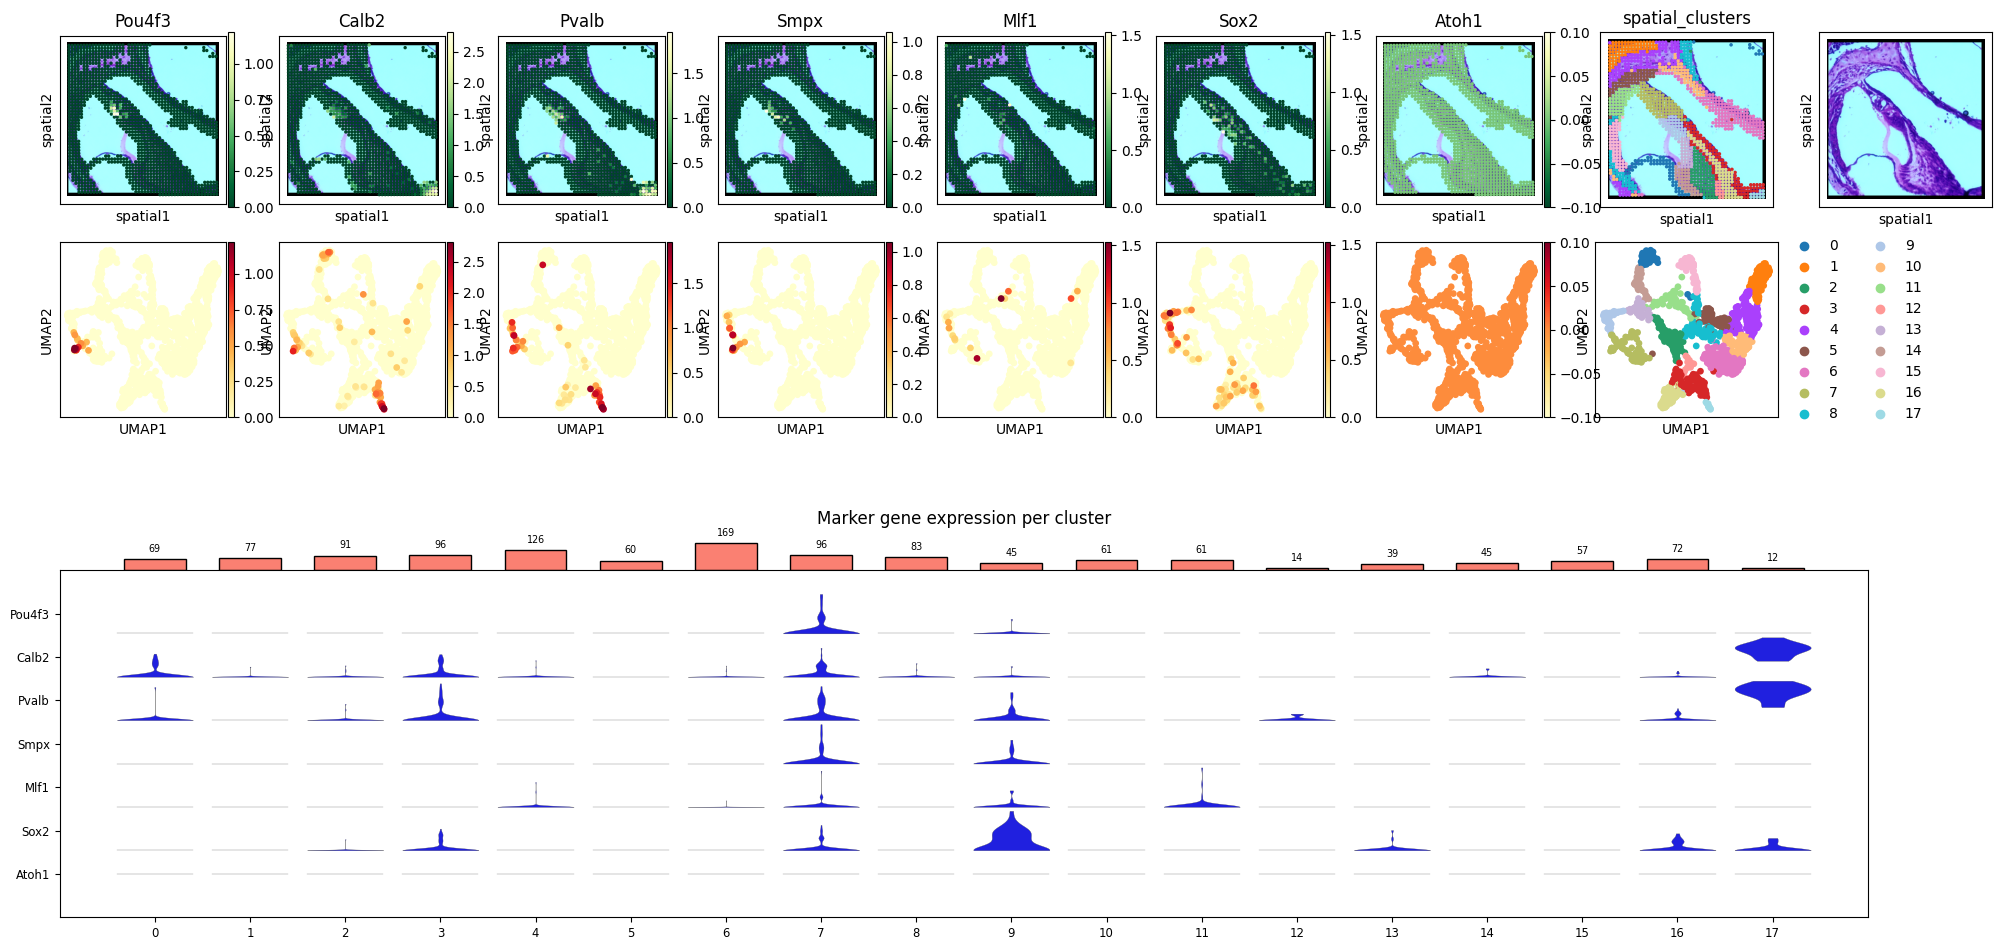

In [85]:
#4th iteration

plt.style.use('default')

# Split into 2 top/bottom subfigures.  Top side will be spatial and umap plots, and bottom side will be "stacked violin" plot
fig = plt.figure(figsize=(25, 10))

subfigs = fig.subfigures(2,1)

#subfigs[0].subplots_adjust(hspace=0.5)

ax0 = subfigs[0].subplots(2, num_genes+2)
ax_col = 0

for gene in marker_genes:
    sc.pl.spatial(vis_adata, img_key="hires", color=gene, size=1, library_id="spatialdata_hires_image", ax=ax0[0][ax_col], color_map="YlGn_r", show=False)
    sc.pl.umap(vis_adata, color=gene, ax=ax0[1][ax_col], color_map="YlOrRd", na_color="gray", show=False)

    # remove umap title (using title=None doesn't work)
    ax0[1][ax_col].set_title("")
    ax_col +=1

# clusters
sc.pl.spatial(vis_adata, img_key="hires", color="spatial_clusters", size=1, library_id="spatialdata_hires_image", legend_loc=None, ax=ax0[0][ax_col], show=False)
sc.pl.umap(vis_adata, color="spatial_clusters", ax=ax0[1][ax_col], show=False)

# remove umap title (using title=None doesn't work)
ax0[1][ax_col].set_title("")
ax_col +=1

# blank image
sc.pl.spatial(vis_adata, img_key="hires", color=None, size=1, library_id="spatialdata_hires_image", ax=ax0[0][ax_col], show=False)

# remove axes for ax0[ax_row][1]
ax0[1][ax_col].axis("off")

# Stacked Violin plot
ax1 = subfigs[1].subplots(nrows=1, ncols=1)

violin_fig = sc.pl.stacked_violin(vis_adata, marker_genes, title="Marker gene expression per cluster", groupby="spatial_clusters", ax=ax1, row_palette="Blue", show=False, return_fig=True)

# Remove the existing legend and add a new vertically-oriented one
violin_fig.add_totals()
violin_fig.make_figure()

violin_axes = violin_fig.fig.get_axes()

# For some reason, deleting all axes and remaking the figure makes it without the spacer above the plot (which was in ax[2] I think)
for ax in violin_axes:
    violin_fig.fig.delaxes(ax)

violin_fig.swap_axes()
violin_fig.make_figure()

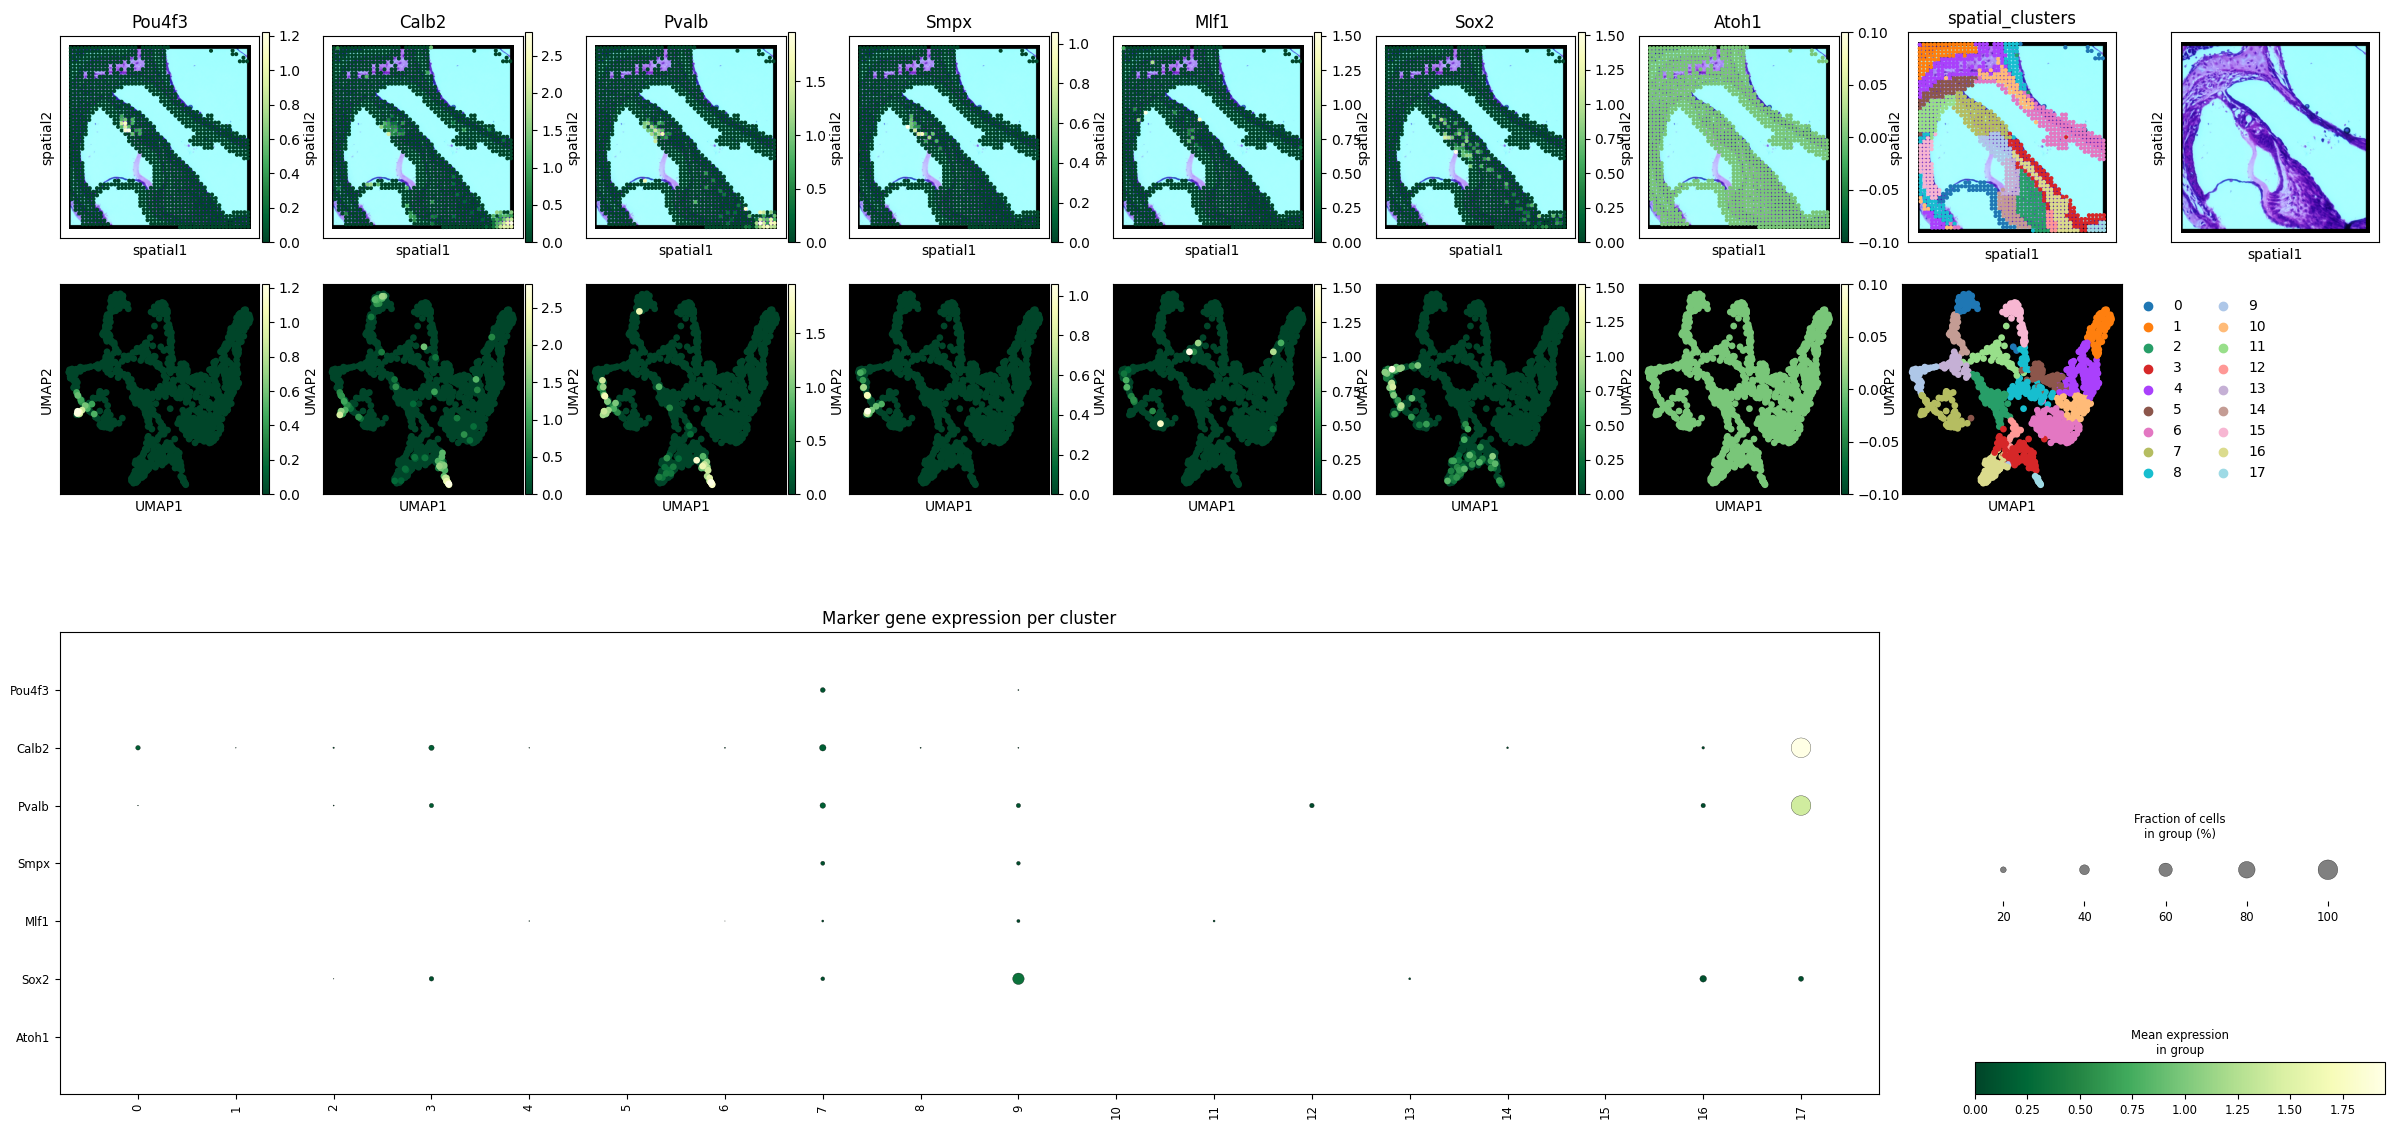

In [86]:
#4th iteration

plt.style.use('default')

# Split into 2 top/bottom subfigures.  Top side will be spatial and umap plots, and bottom side will be "stacked violin" plot
fig = plt.figure(figsize=(30, 12))

subfigs = fig.subfigures(2,1)

#subfigs[0].subplots_adjust(hspace=0.5)

ax0 = subfigs[0].subplots(2, num_genes+2)
ax_col = 0

for gene in marker_genes:
    sc.pl.spatial(vis_adata, img_key="hires", color=gene, size=1, library_id="spatialdata_hires_image", ax=ax0[0][ax_col], color_map="YlGn_r", show=False)
    sc.pl.umap(vis_adata, color=gene, ax=ax0[1][ax_col], color_map="YlGn_r", na_color="gray", show=False)

    # remove umap title (using title=None doesn't work)
    ax0[1][ax_col].set_title("")
    ax0[1][ax_col].set_facecolor("#000000")
    ax_col +=1

# clusters
sc.pl.spatial(vis_adata, img_key="hires", color="spatial_clusters", size=1, library_id="spatialdata_hires_image", legend_loc=None, ax=ax0[0][ax_col], show=False)
sc.pl.umap(vis_adata, color="spatial_clusters", ax=ax0[1][ax_col], show=False)

# remove umap title (using title=None doesn't work)
ax0[1][ax_col].set_title("")
ax0[1][ax_col].set_facecolor("#000000")
ax_col +=1

# blank image
sc.pl.spatial(vis_adata, img_key="hires", color=None, size=1, library_id="spatialdata_hires_image", ax=ax0[0][ax_col], show=False)

# remove axes for ax0[ax_row][1]
ax0[1][ax_col].axis("off")

# Stacked Violin plot
ax1 = subfigs[1].subplots(nrows=1, ncols=1)

dotplot_fig = sc.pl.dotplot(vis_adata, marker_genes, title="Marker gene expression per cluster", groupby="spatial_clusters", ax=ax1, swap_axes=True, cmap="YlGn_r", show=False, return_fig=True)
dotplot_fig.make_figure()

dotplot_axes = dotplot_fig.fig.get_axes()

# For some reason, deleting all axes and remaking the figure makes it without the spacer above the plot (which was in ax[2] I think)
for ax in dotplot_axes:
    dotplot_fig.fig.delaxes(ax)

dotplot_fig.make_figure()
#dotplot_fig.get_axes()["mainplot_ax"].patch.set_facecolor("white")